## IMPORT LIBRARIES

In [171]:
import pandas as pd
import numpy as np
import json
from sklearn.utils import shuffle
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt


### OPENING DATASET AND LOAD TO A DATAFRAME

In [172]:
file = open(
    "content.json", encoding='utf8')
data = json.load(file)
df = pd.DataFrame(data)
df.head()


,id,author,content,crawled_at,picture_count,processed,source,title,topic,url,category
0,2,Lâm Thỏa,"*Việt Nam - Malaysia: 20h thứ Tư 8/6, trên VnE...",2022-06-07 14:05:51.433712,2,0,None,HLV Malaysia dọa ngáng đường Việt Nam,Thể thao,https://vnexpress.net/hlv-malaysia-doa-ngang-d...,0
1,3,Thanh Tâm,"""Các khu dân cư của thành phố Severodonetsk đã...",2022-06-07 14:05:51.797545,2,0,None,Nga tuyên bố 'giải phóng' hoàn toàn khu dân cư...,Thế giới,https://vnexpress.net/nga-tuyen-bo-giai-phong-...,1
2,4,Thảo Mi,"Ngày 7/6, phiên xử phúc thẩm ông Tất Thành Can...",2022-06-07 14:05:53.482540,2,0,None,Ông Tất Thành Cang được đề nghị giảm án,Pháp luật,https://vnexpress.net/ong-tat-thanh-cang-duoc-...,1
3,5,Quốc Thắng,"Chiều 7/6, Khoa bị Công an quận Phú Nhuận phối...",2022-06-07 14:05:53.848085,2,0,None,Nghi can sát hại cha bị bắt,Pháp luật,https://vnexpress.net/nghi-can-sat-hai-cha-bi-...,1
4,6,Vũ Hoàng,"Thủ tướng Anh Boris Johnson hôm 6/6 đã ""thoát ...",2022-06-07 14:05:54.226303,1,0,None,Sóng gió chờ đón Thủ tướng Anh hậu bỏ phiếu bấ...,Thế giới,https://vnexpress.net/thoat-hiem-bat-tin-nhiem...,1


### DROP UNNECESSARY COLUMNS

In [173]:
print(df.shape)
columns = ['id', 'crawled_at', 'processed', 'source', 'topic']
# Drop topic columns since it contributes a lot to the final output (category)
df = df.drop(columns=columns)


(19411, 11)


In [174]:
print(df.shape)


(19411, 6)


### SHOW COLUMNS' DATA TYPES AND COUNT NON-NULL VALUES

In [175]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19411 entries, 0 to 19410
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         19411 non-null  object
 1   content        19411 non-null  object
 2   picture_count  19411 non-null  int64 
 3   title          19411 non-null  object
 4   url            19411 non-null  object
 5   category       19411 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 910.0+ KB


As this project focus on content of the post, we would focus on content field.

In [176]:
content_array = np.array(df['content'])


Remove marks and lower case all words

In [177]:
def standardize_text(newArr):
    newArr = re.sub('/([\u0041-\u005A\u0061-\u007A\u00AA\u00B5\u00BA\u00C0-\u00D6\u00D8-\u00F6\u00F8-\u02C1\u02C6-\u02D1\u02E0-\u02E4\u02EC\u02EE\u0370-\u0374\u0376\u0377\u037A-\u037D\u0386\u0388-\u038A\u038C\u038E-\u03A1\u03A3-\u03F5\u03F7-\u0481\u048A-\u0527\u0531-\u0556\u0559\u0561-\u0587\u05D0-\u05EA\u05F0-\u05F2\u0620-\u064A\u066E\u066F\u0671-\u06D3\u06D5\u06E5\u06E6\u06EE\u06EF\u06FA-\u06FC\u06FF\u0710\u0712-\u072F\u074D-\u07A5\u07B1\u07CA-\u07EA\u07F4\u07F5\u07FA\u0800-\u0815\u081A\u0824\u0828\u0840-\u0858\u08A0\u08A2-\u08AC\u0904-\u0939\u093D\u0950\u0958-\u0961\u0971-\u0977\u0979-\u097F\u0985-\u098C\u098F\u0990\u0993-\u09A8\u09AA-\u09B0\u09B2\u09B6-\u09B9\u09BD\u09CE\u09DC\u09DD\u09DF-\u09E1\u09F0\u09F1\u0A05-\u0A0A\u0A0F\u0A10\u0A13-\u0A28\u0A2A-\u0A30\u0A32\u0A33\u0A35\u0A36\u0A38\u0A39\u0A59-\u0A5C\u0A5E\u0A72-\u0A74\u0A85-\u0A8D\u0A8F-\u0A91\u0A93-\u0AA8\u0AAA-\u0AB0\u0AB2\u0AB3\u0AB5-\u0AB9\u0ABD\u0AD0\u0AE0\u0AE1\u0B05-\u0B0C\u0B0F\u0B10\u0B13-\u0B28\u0B2A-\u0B30\u0B32\u0B33\u0B35-\u0B39\u0B3D\u0B5C\u0B5D\u0B5F-\u0B61\u0B71\u0B83\u0B85-\u0B8A\u0B8E-\u0B90\u0B92-\u0B95\u0B99\u0B9A\u0B9C\u0B9E\u0B9F\u0BA3\u0BA4\u0BA8-\u0BAA\u0BAE-\u0BB9\u0BD0\u0C05-\u0C0C\u0C0E-\u0C10\u0C12-\u0C28\u0C2A-\u0C33\u0C35-\u0C39\u0C3D\u0C58\u0C59\u0C60\u0C61\u0C85-\u0C8C\u0C8E-\u0C90\u0C92-\u0CA8\u0CAA-\u0CB3\u0CB5-\u0CB9\u0CBD\u0CDE\u0CE0\u0CE1\u0CF1\u0CF2\u0D05-\u0D0C\u0D0E-\u0D10\u0D12-\u0D3A\u0D3D\u0D4E\u0D60\u0D61\u0D7A-\u0D7F\u0D85-\u0D96\u0D9A-\u0DB1\u0DB3-\u0DBB\u0DBD\u0DC0-\u0DC6\u0E01-\u0E30\u0E32\u0E33\u0E40-\u0E46\u0E81\u0E82\u0E84\u0E87\u0E88\u0E8A\u0E8D\u0E94-\u0E97\u0E99-\u0E9F\u0EA1-\u0EA3\u0EA5\u0EA7\u0EAA\u0EAB\u0EAD-\u0EB0\u0EB2\u0EB3\u0EBD\u0EC0-\u0EC4\u0EC6\u0EDC-\u0EDF\u0F00\u0F40-\u0F47\u0F49-\u0F6C\u0F88-\u0F8C\u1000-\u102A\u103F\u1050-\u1055\u105A-\u105D\u1061\u1065\u1066\u106E-\u1070\u1075-\u1081\u108E\u10A0-\u10C5\u10C7\u10CD\u10D0-\u10FA\u10FC-\u1248\u124A-\u124D\u1250-\u1256\u1258\u125A-\u125D\u1260-\u1288\u128A-\u128D\u1290-\u12B0\u12B2-\u12B5\u12B8-\u12BE\u12C0\u12C2-\u12C5\u12C8-\u12D6\u12D8-\u1310\u1312-\u1315\u1318-\u135A\u1380-\u138F\u13A0-\u13F4\u1401-\u166C\u166F-\u167F\u1681-\u169A\u16A0-\u16EA\u1700-\u170C\u170E-\u1711\u1720-\u1731\u1740-\u1751\u1760-\u176C\u176E-\u1770\u1780-\u17B3\u17D7\u17DC\u1820-\u1877\u1880-\u18A8\u18AA\u18B0-\u18F5\u1900-\u191C\u1950-\u196D\u1970-\u1974\u1980-\u19AB\u19C1-\u19C7\u1A00-\u1A16\u1A20-\u1A54\u1AA7\u1B05-\u1B33\u1B45-\u1B4B\u1B83-\u1BA0\u1BAE\u1BAF\u1BBA-\u1BE5\u1C00-\u1C23\u1C4D-\u1C4F\u1C5A-\u1C7D\u1CE9-\u1CEC\u1CEE-\u1CF1\u1CF5\u1CF6\u1D00-\u1DBF\u1E00-\u1F15\u1F18-\u1F1D\u1F20-\u1F45\u1F48-\u1F4D\u1F50-\u1F57\u1F59\u1F5B\u1F5D\u1F5F-\u1F7D\u1F80-\u1FB4\u1FB6-\u1FBC\u1FBE\u1FC2-\u1FC4\u1FC6-\u1FCC\u1FD0-\u1FD3\u1FD6-\u1FDB\u1FE0-\u1FEC\u1FF2-\u1FF4\u1FF6-\u1FFC\u2071\u207F\u2090-\u209C\u2102\u2107\u210A-\u2113\u2115\u2119-\u211D\u2124\u2126\u2128\u212A-\u212D\u212F-\u2139\u213C-\u213F\u2145-\u2149\u214E\u2183\u2184\u2C00-\u2C2E\u2C30-\u2C5E\u2C60-\u2CE4\u2CEB-\u2CEE\u2CF2\u2CF3\u2D00-\u2D25\u2D27\u2D2D\u2D30-\u2D67\u2D6F\u2D80-\u2D96\u2DA0-\u2DA6\u2DA8-\u2DAE\u2DB0-\u2DB6\u2DB8-\u2DBE\u2DC0-\u2DC6\u2DC8-\u2DCE\u2DD0-\u2DD6\u2DD8-\u2DDE\u2E2F\u3005\u3006\u3031-\u3035\u303B\u303C\u3041-\u3096\u309D-\u309F\u30A1-\u30FA\u30FC-\u30FF\u3105-\u312D\u3131-\u318E\u31A0-\u31BA\u31F0-\u31FF\u3400-\u4DB5\u4E00-\u9FCC\uA000-\uA48C\uA4D0-\uA4FD\uA500-\uA60C\uA610-\uA61F\uA62A\uA62B\uA640-\uA66E\uA67F-\uA697\uA6A0-\uA6E5\uA717-\uA71F\uA722-\uA788\uA78B-\uA78E\uA790-\uA793\uA7A0-\uA7AA\uA7F8-\uA801\uA803-\uA805\uA807-\uA80A\uA80C-\uA822\uA840-\uA873\uA882-\uA8B3\uA8F2-\uA8F7\uA8FB\uA90A-\uA925\uA930-\uA946\uA960-\uA97C\uA984-\uA9B2\uA9CF\uAA00-\uAA28\uAA40-\uAA42\uAA44-\uAA4B\uAA60-\uAA76\uAA7A\uAA80-\uAAAF\uAAB1\uAAB5\uAAB6\uAAB9-\uAABD\uAAC0\uAAC2\uAADB-\uAADD\uAAE0-\uAAEA\uAAF2-\uAAF4\uAB01-\uAB06\uAB09-\uAB0E\uAB11-\uAB16\uAB20-\uAB26\uAB28-\uAB2E\uABC0-\uABE2\uAC00-\uD7A3\uD7B0-\uD7C6\uD7CB-\uD7FB\uF900-\uFA6D\uFA70-\uFAD9\uFB00-\uFB06\uFB13-\uFB17\uFB1D\uFB1F-\uFB28\uFB2A-\uFB36\uFB38-\uFB3C\uFB3E\uFB40\uFB41\uFB43\uFB44\uFB46-\uFBB1\uFBD3-\uFD3D\uFD50-\uFD8F\uFD92-\uFDC7\uFDF0-\uFDFB\uFE70-\uFE74\uFE76-\uFEFC\uFF21-\uFF3A\uFF41-\uFF5A\uFF66-\uFFBE\uFFC2-\uFFC7\uFFCA-\uFFCF\uFFD2-\uFFD7\uFFDA-\uFFDC]+)/g', ' ', content_array[i])
    newArr = newArr.lower()

    newArr = newArr.split()
    newArr = ' '.join(newArr)
    newArr = re.sub(r'[0-9]+', '', newArr)
    return newArr

In [178]:
corpus = []

for i in range(0, 19410):
    newArr = standardize_text(newArr)
    corpus.append(newArr)


Example of a post after preprocessing

In [179]:
corpus[0]


'*việt nam - malaysia: h thứ tư /, trên vnexpress. malaysia đã bị loại sau khi thua hàn quốc - và thái lan -. bởi vậy, lượt cuối gặp việt nam chỉ mang ý nghĩa thủ tục đối với họ. tuy nhiên, kết quả trận đấu đó sẽ ảnh hưởng đến cục diện bảng c - nơi hàn quốc, thái lan và việt nam đều có cơ hội vào tứ kết. trên nhật báo malaysia sinar harian, hlv maloney khẳng định: "chúng tôi sẽ đánh giá lại các vấn đề về nhân sự và chuyên môn. chắc chắn, nhiều cầu thủ mới sẽ được trao cơ hội ở trận cuối. tôi hy vọng malaysia có thể giành ít nhất một điểm trước việt nam". ở lượt cuối ngày mai /, việt nam cần đánh bại malaysia, và hy vọng cặp đấu còn lại giữa thái lan và hàn quốc có kết quả thắng bại hoặc hòa nhau -, - hoặc -. nếu hai đối thủ cạnh tranh hòa nhau -, việt nam sẽ bị loại kể cả thắng malaysia. bởi lúc đó, ba đội bằng điểm nhau, nhưng đội bóng của hlv gong oh-kyun kém số bàn thắng trong các trận đối đầu với hai đối thủ này. u châu á  từng được xem là giải đấu trọng điểm của bóng đá malaysia. 

## Transform the data using CountVectorizer

In [180]:
countv = CountVectorizer(max_features=1200)
X = countv.fit_transform(corpus).toarray()
y = df.iloc[0:19410, 5].values


In [181]:
X


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 13,  0],
       ...,
       [ 0,  0,  7, ...,  0,  0,  2],
       [ 0,  0,  0, ...,  0,  2,  2],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

### Most used tokens in the dataset

In [182]:
countv.get_feature_names()


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['ai',
 'an',
 'anh',
 'apple',
 'arabia',
 'australia',
 'ba',
 'ban',
 'bang',
 'bao',
 'bay',
 'binh',
 'biên',
 'biến',
 'biết',
 'biển',
 'biểu',
 'biện',
 'biệt',
 'buổi',
 'buộc',
 'bà',
 'bài',
 'bàn',
 'bày',
 'bác',
 'bán',
 'bánh',
 'báo',
 'bãi',
 'bè',
 'bé',
 'bên',
 'bình',
 'bí',
 'bóng',
 'bùng',
 'băng',
 'bước',
 'bạc',
 'bạch',
 'bại',
 'bạn',
 'bạo',
 'bản',
 'bảng',
 'bảo',
 'bất',
 'bầu',
 'bật',
 'bắc',
 'bắt',
 'bằng',
 'bến',
 'bền',
 'bệnh',
 'bị',
 'bỏ',
 'bố',
 'bối',
 'bồi',
 'bổ',
 'bộ',
 'bởi',
 'bức',
 'bữa',
 'ca',
 'cam',
 'can',
 'cao',
 'cha',
 'chi',
 'chia',
 'chiếc',
 'chiếm',
 'chiến',
 'chiếu',
 'chiều',
 'cho',
 'chu',
 'chung',
 'chuyên',
 'chuyến',
 'chuyển',
 'chuyện',
 'chuẩn',
 'chuỗi',
 'cháu',
 'cháy',
 'chân',
 'châu',
 'chí',
 'chính',
 'chóng',
 'chú',
 'chúng',
 'chăm',
 'chơi',
 'chưa',
 'chương',
 'chạm',
 'chạy',
 'chấp',
 'chất',
 'chậm',
 'chắc',
 'chắn',
 'chẳng',
 'chặn',
 'chặt',
 'chế',
 'chết',
 'chỉ',
 'chỉnh',
 'chị',
 '

In [183]:
tokens_count = X


In [184]:
counts = pd.DataFrame(tokens_count,
                      columns=countv.get_feature_names_out())


In [185]:
counts


,ai,an,anh,apple,arabia,australia,ba,ban,bang,bao,...,ương,ước,ảnh,ấn,ấy,ẩn,ổn,ủng,ủy,ứng
0,0,0,0,0,0,1,2,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,13,0
3,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,8,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19405,0,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19406,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19407,0,0,7,0,0,0,0,0,0,0,...,0,0,5,1,0,1,0,0,0,2
19408,0,0,0,0,0,0,0,3,0,0,...,0,0,1,0,0,0,0,0,2,2


## Split dataset into training and testing sets

In [186]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)


## LOGISTIC REGRESSION

In [187]:

lr_classifier = LogisticRegression(random_state=0)
lr_classifier.fit(X_train, y_train)


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [188]:
print(X_test.shape)


(3882, 1200)


In [189]:
print(X_test)


[[ 0  0  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  1]
 ...
 [ 0  2  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


### Test and return Confusion Matrix

In [190]:

y_pred = lr_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[1646  301]
 [ 280 1655]]


### Print Report

In [191]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1947
           1       0.85      0.86      0.85      1935

    accuracy                           0.85      3882
   macro avg       0.85      0.85      0.85      3882
weighted avg       0.85      0.85      0.85      3882



In [192]:

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100, 2)))


Accuracy: 85.03


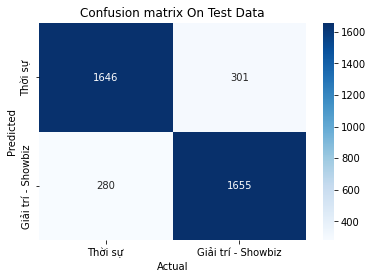

In [193]:
new_cm = pd.DataFrame(cm, index=[
                      'Thời sự', 'Giải trí - Showbiz'], columns=['Thời sự', 'Giải trí - Showbiz'])
sns.heatmap(new_cm, cmap='Blues', annot=True, fmt='', xticklabels=[
            'Thời sự', 'Giải trí - Showbiz'], yticklabels=['Thời sự', 'Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()


## GAUSSIAN NAIVE BAYES

In [194]:


gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)


GaussianNB()

### Confusion matrix

In [195]:
y_pred = gnb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[1532  415]
 [ 263 1672]]


### Report

In [196]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1947
           1       0.80      0.86      0.83      1935

    accuracy                           0.83      3882
   macro avg       0.83      0.83      0.83      3882
weighted avg       0.83      0.83      0.83      3882



In [197]:
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100, 2)))


Accuracy: 82.53


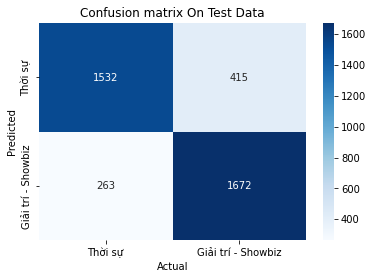

In [198]:
new_cm = pd.DataFrame(cm, index=[
                      'Thời sự', 'Giải trí - Showbiz'], columns=['Thời sự', 'Giải trí - Showbiz'])
sns.heatmap(new_cm, cmap='Blues', annot=True, fmt='', xticklabels=[
            'Thời sự', 'Giải trí - Showbiz'], yticklabels=['Thời sự', 'Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()


## BERNOULLI NAIVE BAYES

In [199]:
bnb_classifier = BernoulliNB()
bnb_classifier.fit(X_train, y_train)


BernoulliNB()

### Confusion Matrix

In [200]:
y_pred = bnb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[1537  410]
 [ 279 1656]]


### Report

In [201]:
print(classification_report(y_test, y_pred))
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100, 2)))


              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1947
           1       0.80      0.86      0.83      1935

    accuracy                           0.82      3882
   macro avg       0.82      0.82      0.82      3882
weighted avg       0.82      0.82      0.82      3882

Accuracy: 82.25


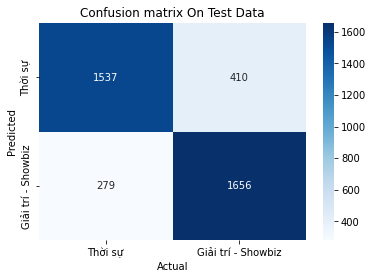

In [202]:
new_cm = pd.DataFrame(cm, index=[
                      'Thời sự', 'Giải trí - Showbiz'], columns=['Thời sự', 'Giải trí - Showbiz'])
sns.heatmap(new_cm, cmap='Blues', annot=True, fmt='', xticklabels=[
            'Thời sự', 'Giải trí - Showbiz'], yticklabels=['Thời sự', 'Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()


## SUPPORT VECTOR MACHINES

In [203]:
svm_classifier = NuSVC(max_iter=200)
svm_classifier.fit(X_train, y_train)


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


NuSVC(max_iter=200)

### Confusion Matrix

In [204]:
y_pred = svm_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[1343  604]
 [ 178 1757]]


### Report

In [205]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.69      0.77      1947
           1       0.74      0.91      0.82      1935

    accuracy                           0.80      3882
   macro avg       0.81      0.80      0.80      3882
weighted avg       0.81      0.80      0.80      3882



In [206]:
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100, 2)))


Accuracy: 79.86


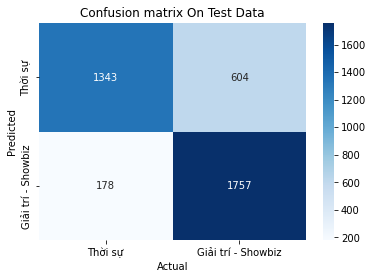

In [207]:
new_cm = pd.DataFrame(cm, index=[
                      'Thời sự', 'Giải trí - Showbiz'], columns=['Thời sự', 'Giải trí - Showbiz'])
sns.heatmap(new_cm, cmap='Blues', annot=True, fmt='', xticklabels=[
            'Thời sự', 'Giải trí - Showbiz'], yticklabels=['Thời sự', 'Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()


TESTING ANY POST HERE:

In [220]:
text = input()
text = standardize_text(text)

test = []
test.append(text)

In [221]:
test = countv.transform(test).toarray()

You may change the model below to gnb_classifier (Gaussian Naive Bayes), bnb_classifier (Bernoulli Naive Bayes) or svm_classifier (SVM)

In [222]:
res = lr_classifier.predict(test)
res[0]

1